In [1]:
# Import the required modules.

import numpy as np
import pandas as pd
import json
import cv2
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec

from imutils import perspective
from imutils import contours
import imutils

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# Set a start point to remove the non-tag tool results.
preset = 5087

# Read in the zooniverse classifications.
data = pd.read_csv('astro-ecology-classifications.csv')[preset:]
data.head()

classification_id      user_name    user_id               user_ip  \
5087          135872963  RossMcWhirter  1813215.0  1a400102c1fc2a1080f9   
5088          135872977  RossMcWhirter  1813215.0  1a400102c1fc2a1080f9   
5089          135873070  RossMcWhirter  1813215.0  1a400102c1fc2a1080f9   
5090          135873112  RossMcWhirter  1813215.0  1a400102c1fc2a1080f9   
5091          135873216  RossMcWhirter  1813215.0  1a400102c1fc2a1080f9   

      workflow_id                    workflow_name  workflow_version  \
5087         7916  Knowsley Safari rhino enclosure            67.165   
5088         7916  Knowsley Safari rhino enclosure            67.165   
5089         7916  Knowsley Safari rhino enclosure            67.165   
5090         7916  Knowsley Safari rhino enclosure            67.165   
5091         7916  Knowsley Safari rhino enclosure            67.165   

                   created_at  gold_standard  expert  \
5087  2018-12-10 17:30:41 UTC            NaN     NaN   
5088  2018-12-10 17:30:44 UTC            NaN     NaN   
5089  2018-12-10 17:31:21 UTC            NaN     NaN   
5090  2018-12-10 17:31:41 UTC            NaN     NaN   
5091  2018-12-10 17:32:09 UTC            NaN     NaN   

                                               metadata  \
5087  {"source":"api","session":"dd0eff20c2f11dc45f8...   
5088  {"source":"api","session":"dd0eff20c2f11dc45f8...   
5089  {"source":"api","session":"dd0eff20c2f11dc45f8...   
5090  {"source":"api","session":"dd0eff20c2f11dc45f8...   
5091  {"source":"api","session":"dd0eff20c2f11dc45f8...   

                                            annotations  \
5087  [{"task":"T0","task_label":"Use the tools belo...   
5088  [{"task":"T0","task_label":"Use the tools belo...   
5089  [{"task":"T0","task_label":"Use the tools belo...   
5090  [{"task":"T0","task_label":"Use the tools belo...   
5091  [{"task":"T0","task_label":"Use the tools belo...   

                                           subject_data  subject_ids  
5087  {"26793143":{"retired":{"id":23500958,"workflo...     26793143  
5088  {"26793399":{"retired":{"id":23502221,"workflo...     26793399  
5089  {"26795947":{"retired":{"id":23503609,"workflo...     26795947  
5090  {"26793713":{"retired":{"id":23502754,"workflo...     26793713  
5091  {"26783731":{"retired":{"id":23494735,"workflo...     26783731

In [3]:
# Open a set of lists to store import classification data.
classification_id = []
filename = []
tool_label = []
tool = []
x = []
y = []

# Run through each of the rows and extract every tagged coordinate and associated class.
for i in tqdm(range(len(data))):
    place = i+preset
    for j in range(len(json.loads(data.annotations[place])[0]['value'])):
        classification_id.append(data.classification_id[place])
        filename.append(json.loads(data.subject_data[place])[str(data.subject_ids[place])]['Filename'][:-4] + '.png')
        index = json.loads(data.annotations[place])[0]['value'][j]
        tool_label.append(index['tool_label'])
        tool.append(index['tool'])
        x.append(index['x'])
        y.append(index['y'])

In [4]:
# Turn the lists into a pandas dataframe.
df = pd.DataFrame({'classification_id': classification_id, 'filename': filename, 'tool_label': tool_label, 'tool': tool, 'x': x, 'y': y}, columns=['classification_id','filename','tool_label','tool','x','y'])

In [5]:
# Perform some maintenance to change labels to be equal to names file.
df = df[df['tool'] < 3]
df.loc[df['tool'] == 0, 'tool'] = 4
df.loc[df['tool'] == 2, 'tool'] = 3
df.loc[df['tool'] == 1, 'tool'] = 2
df.sort_values(by=['filename'])
df.index = range(len(df))
df

#df.to_csv('E:\\Documents\\PostDoc\\know_fusion_labels\\astroecology_classifications_processed.csv', index=False)

classification_id                 filename tool_label  tool  \
0               135872963  20180412_01_01_0185.png      Rhino     4   
1               135872963  20180412_01_01_0185.png      Rhino     4   
2               135873070  20180412_02_01_0116.png      Rhino     4   
3               135873070  20180412_02_01_0116.png      Rhino     4   
4               135873070  20180412_02_01_0116.png   Antelope     2   
...                   ...                      ...        ...   ...   
715635          203037303  20170717_01_01_0263.png   Antelope     2   
715636          203037303  20170717_01_01_0263.png   Antelope     2   
715637          203037303  20170717_01_01_0263.png   Antelope     2   
715638          203037303  20170717_01_01_0263.png   Antelope     2   
715639          203037303  20170717_01_01_0263.png   Antelope     2   

                 x           y  
0       331.984375  278.000000  
1       358.984375  280.000000  
2       236.984375  264.000000  
3       306.984375  273.000000  
4       293.984375  335.000000  
...            ...         ...  
715635  481.698364    3.445114  
715636  453.945312    6.397568  
715637  443.316467   28.836182  
715638  434.459106    3.445114  
715639  406.706116    1.673645  

[715640 rows x 6 columns]

In [6]:
k = 30000

targ = df.filename[k]

# Read in the images for creating bounding boxes from coordinate tags.
img = cv2.imread(os.path.join('E:\\Documents\\PostDoc\\know_fusion_images', targ))

In [7]:
# Convert into grayscale and into a numpy array.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.array(img)

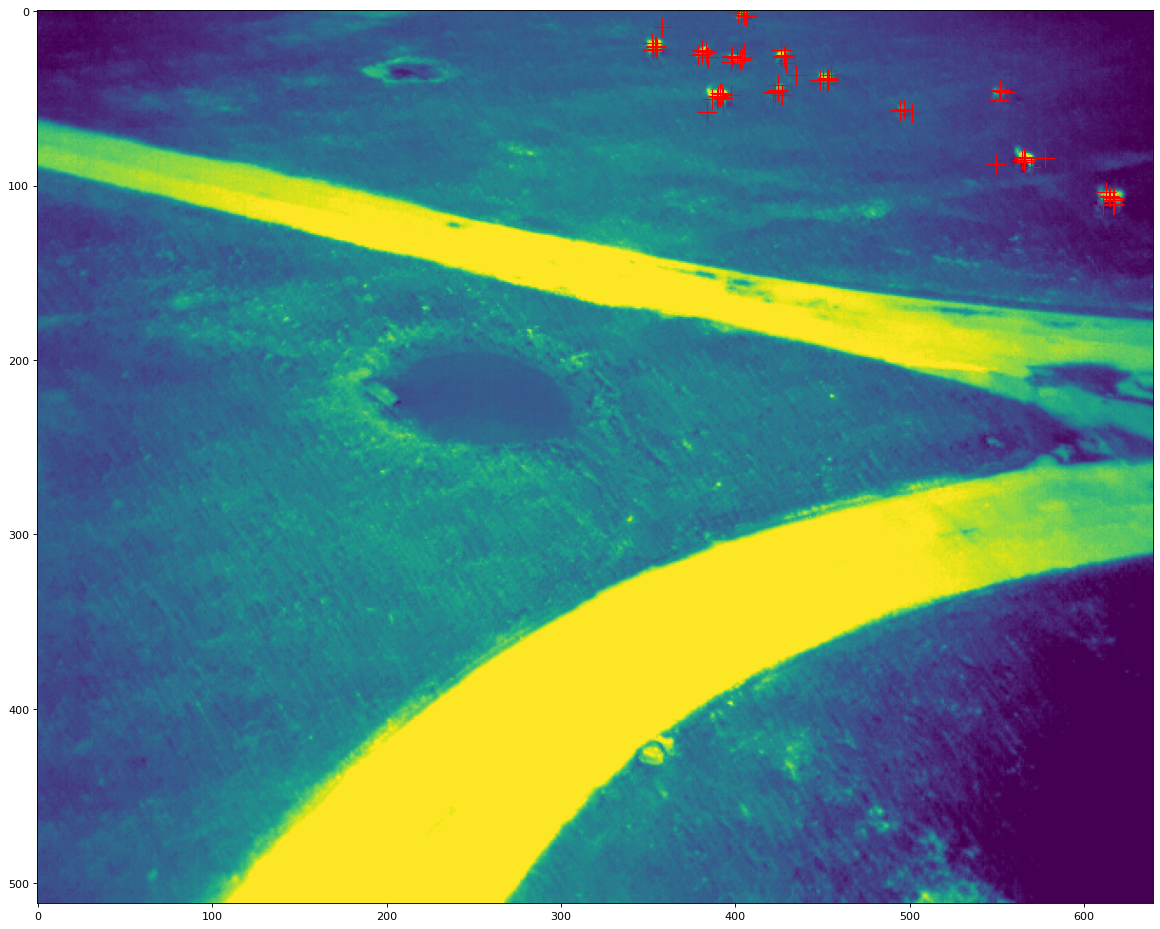

In [8]:
# Plot the image and show the tagged coordinates as crosshairs.
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)

labs = df[df.filename == df.filename[k]]
labs.index = range(len(labs))
for i in range(len(labs)):
    plt.plot(labs.x[i], labs.y[i], 'b+', color='red', markersize = 18)

In [9]:
# For each of the tags, cut out a 20 by 20 pixel region centred on them.

x_t = []
y_t = []
b_t = []

cut = 255 - img

for i in range(len(labs)):
    
    # Get the coordinates of the maximum pixel in the 20x20 pixel region.
    
    xx = np.repeat(np.power(range(640) - labs.x[i], 2.0)[np.newaxis,:], 512, 0)
    
    yy = np.repeat(np.power(range(512) - labs.y[i], 2.0)[np.newaxis,:], 640, 0).transpose()
    
    xy = np.sqrt(xx + yy)
    
    fin = 255 * (xy / np.max(xy))
    
    both = 0.9*fin + 0.1*cut
    
    #dist = np.sqrt(np.power(range(640) - labs.x[i], 2.0) + np.power(range(512) - labs.y[i], 2.0))
    
    x_c = np.where(both == np.amin(both))[0][0]
    y_c = np.where(both == np.amin(both))[1][0]
    
    #dist = np.sqrt(np.power(x_c-cut_reg, 2.0) + np.power(y_c-cut_reg, 2.0))
    #mindist = np.where(dist == np.amin(dist))[0][0]
    
    #x_r = int(round(labs.x[i]-cut_reg))+x_c[mindist]
    #y_r = int(round(labs.y[i]-cut_reg))+y_c[mindist]
    
    #print(x_c[mindist])

    x_t.append(y_c)
    y_t.append(x_c)
    b_t.append(img[x_c, y_c])

<ipython-input-10-68e8b5988e74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-10-68e8b5988e74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-10-68e8b5988e74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

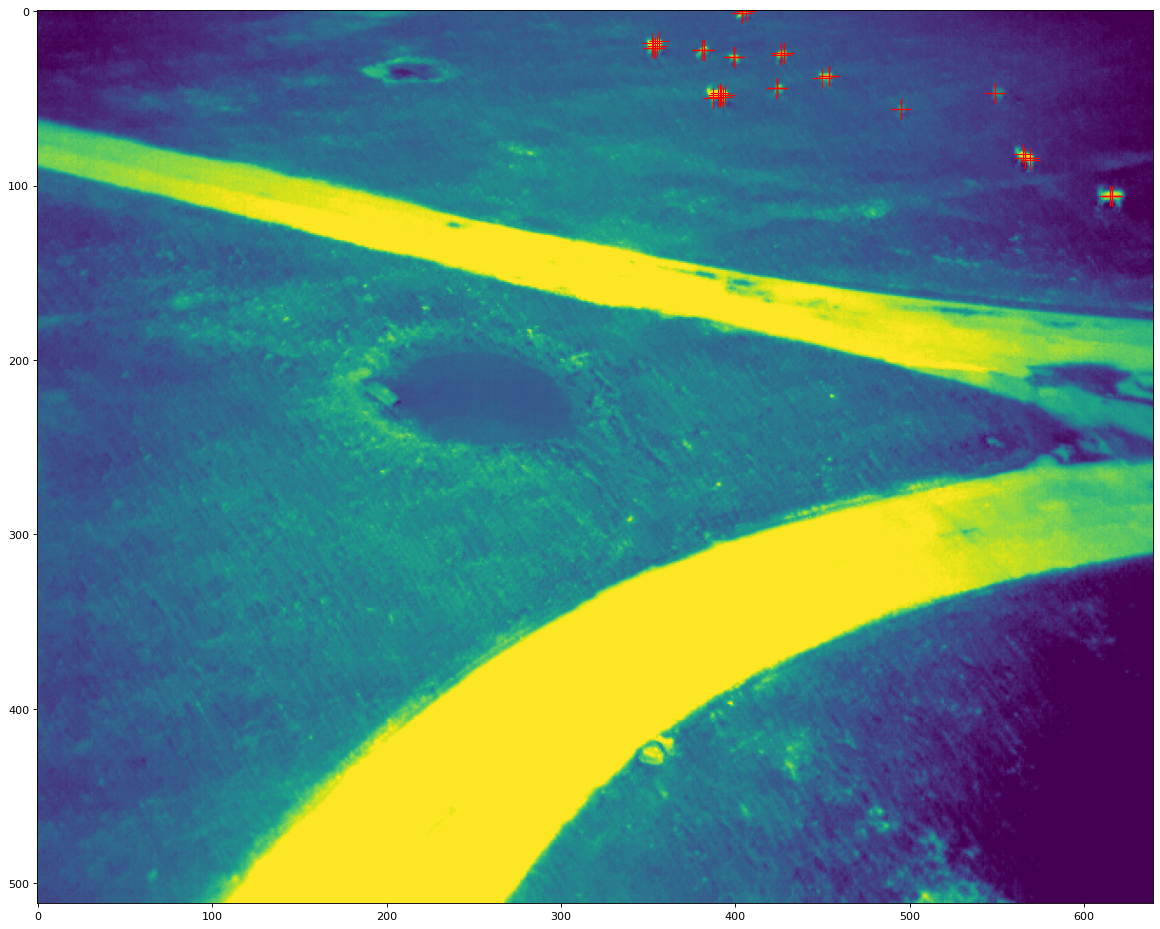

In [10]:
labs['x_t'] = pd.Series(x_t)
labs['y_t'] = pd.Series(y_t)
labs['b_t'] = pd.Series(b_t)

# Plot the image and show the tagged coordinates as crosshairs.
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)

for i in range(len(labs)):
    plt.plot(labs.x_t[i], labs.y_t[i], 'b+', color='red', markersize = 18)

In [11]:
# For each classified image, work out the boxes for each of the tags.

unique_class = np.unique(labs['classification_id'])

for j in range(len(unique_class)):
    labset = labs[labs.classification_id == unique_class[j]]
    labset.sort_values(by=['x'])
    labset.index = range(len(labset))
    
    # Find the boxes.
    
    x_min = []
    x_max = []
    y_min = []
    y_max = []
    
    for k in range(len(labset)):
        
        x_cand_1 = labset.x_t[k]
        x_cand_2 = labset.x_t[k]
        y_cand_1 = labset.y_t[k]
        y_cand_2 = labset.y_t[k]
        
        #for z in range(1):
        
        #x_s_1 = img[:x_cand_1+1,y_cand_1][::-1]
        #x_s_2 = img[x_cand_1:,y_cand_1]
        
        #x_cand_1 = x_cand_1 - np.where(x_s_1 < 127)[0][0]
        #x_cand_2 = x_cand_2 + np.where(x_s_2 < 127)[0][0]
        
        #y_s_1 = img[x_cand_1,:y_cand_1+1][::-1]
        #y_s_2 = img[x_cand_2,y_cand_2:]
        
        #y_s_1 = img[labset.x_t[k],:y_cand_1+1][::-1]
        #y_s_2 = img[labset.x_t[k],y_cand_2:]
        
        #y_cand_1 = y_cand_1 - np.where(y_s_1 < 127)[0][0]
        #y_cand_2 = y_cand_2 + np.where(y_s_2 < 127)[0][0]
            
        #x_min.append(x_cand_1 - np.where(x_s_1 < 127)[0][0])
        #x_max.append(x_cand_2 + np.where(x_s_2 < 127)[0][0])
        
        #y_min.append(y_cand_1 - np.where(y_s_1 < 127)[0][0])
        #y_max.append(y_cand_2 + np.where(y_s_2 < 127)[0][0])
        
        x_min.append(x_cand_1 - 5)
        x_max.append(x_cand_2 + 5)
        
        y_min.append(y_cand_1 - 5)
        y_max.append(y_cand_2 + 5)
        
    labset['x_min'] = x_min
    labset['x_max'] = x_max
    labset['y_min'] = y_min
    labset['y_max'] = y_max
    
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #plt.imshow(img)
    
    #fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #gs  = gridspec.GridSpec(1, 1, height_ratios=[1])
    #ax = plt.subplot(gs[0])

    # Display the image
    #ax.imshow(img)
    
    #for k in range(len(labset)):
    #    rect = patches.Rectangle((x_min[k],y_min[k]),x_max[k]-x_min[k],y_max[k]-y_min[k],linewidth=1,edgecolor='r',facecolor='none')
    #    ax.add_patch(rect)

<ipython-input-11-3c9544d846d7>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labset['x_min'] = x_min
<ipython-input-11-3c9544d846d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labset['x_max'] = x_max
<ipython-input-11-3c9544d846d7>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

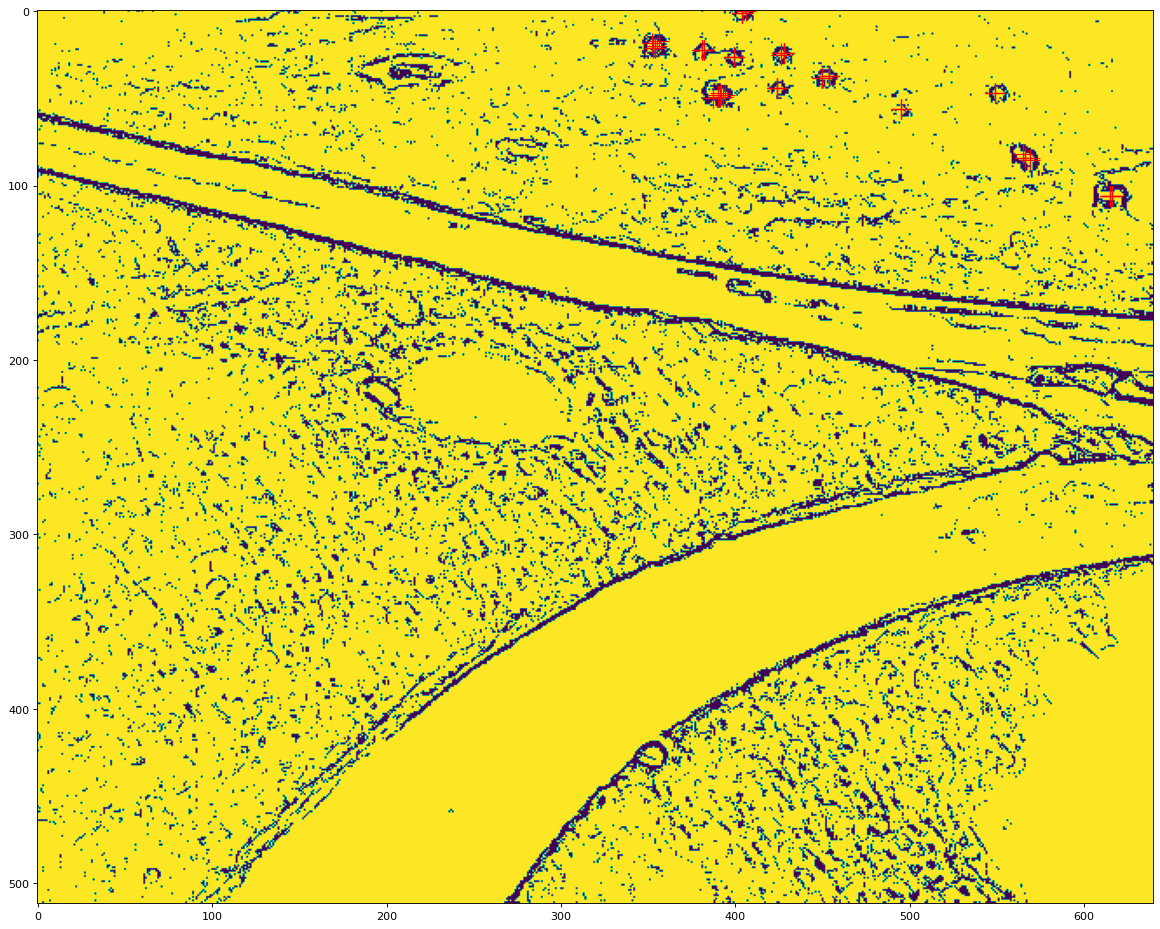

In [12]:
k = 30000

img = cv2.imread(os.path.join('E:\\Documents\\PostDoc\\know_fusion_images', targ))
ori = img.copy()
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.medianBlur(img,5)

sizey, sizex = img.shape

rang = 5
os = 2

th = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,rang,os)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(th)

for i in range(len(labs)):
    plt.plot(labs.x_t[i], labs.y_t[i], 'b+', color='red', markersize = 18)

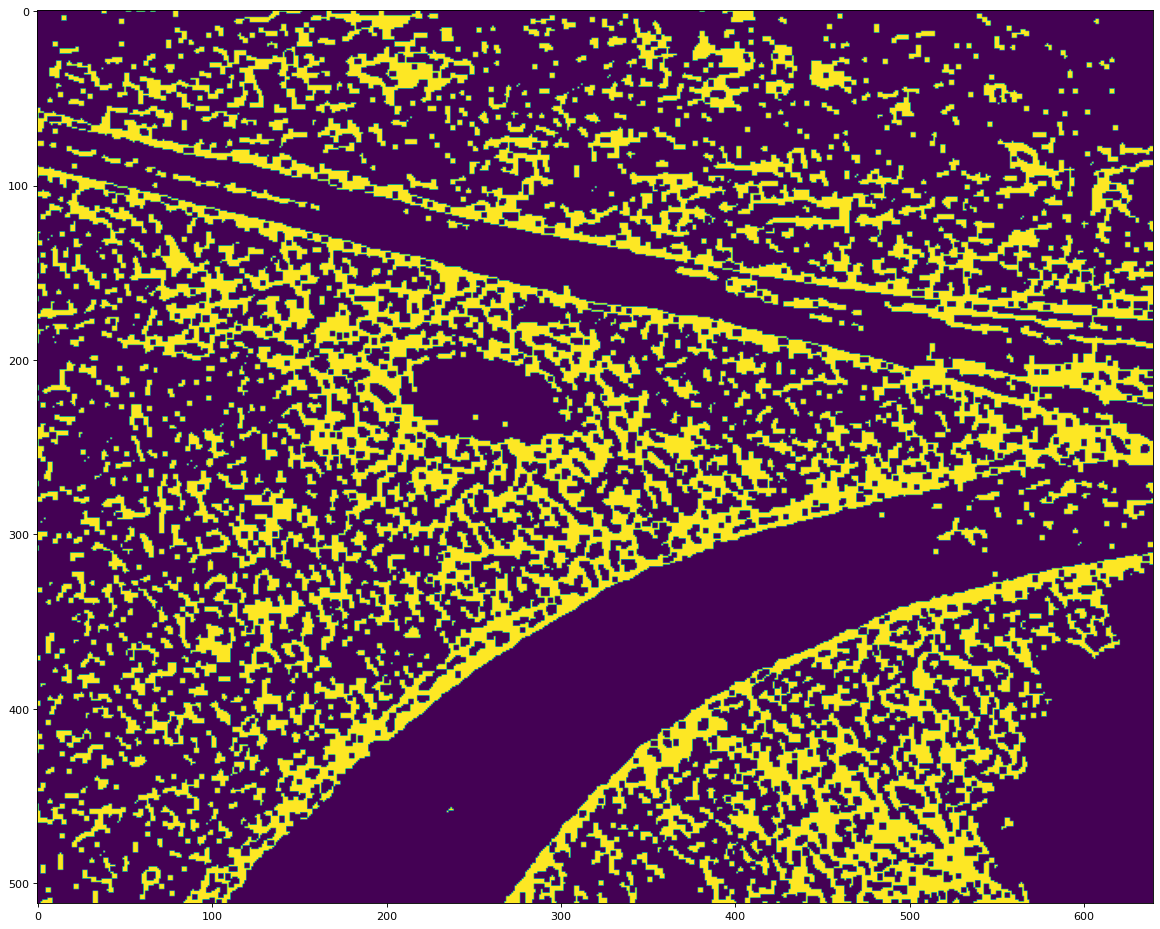

In [13]:
image = th
image = cv2.bitwise_not(image)

edged = cv2.Canny(image, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(edged)

cnts, harchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [14]:
cv2.drawContours(th, cnts[0], 0, (0, 255, 0), -1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [15]:
(cnts, _) = contours.sort_contours(cnts)

In [16]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

areas = []

box_x = []
box_y = []
box_w = []
box_h = []

for c in cnts:

    areas.append(cv2.contourArea(c))

    orig = img.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    box = perspective.order_points(box)

    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    x, y, w, h = cv2.boundingRect(c)
    
    box_x.append(x)
    box_y.append(y)
    box_w.append(w)
    box_h.append(h)

<ipython-input-17-179ea882b1b9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['empty'] = 0
<ipython-input-17-179ea882b1b9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['empty'][i] = 1
C:\Users\Ross\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<i

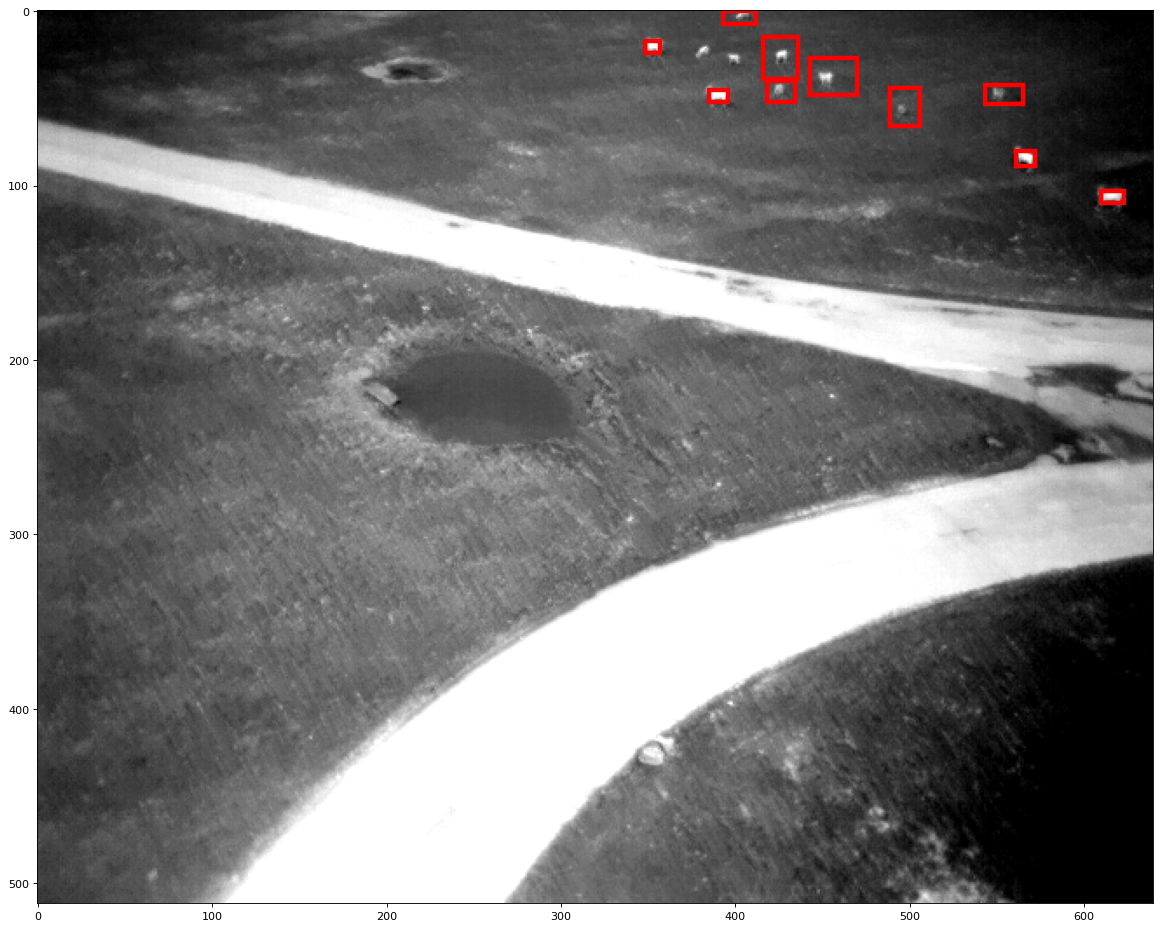

In [17]:
# Turn the lists into a pandas dataframe.
boxes = pd.DataFrame({'x': box_x, 'y': box_y, 'w': box_w, 'h': box_h}, columns=['x','y','w','h'])

boxes['a'] = boxes['w'] * boxes['h']

boxes = boxes[boxes['a'] < 1000]

boxes['keep'] = 0

boxes.index = range(len(boxes))

# Reject boxes without a tag inside.

for i in range(len(labs)):
    for j in range(len(boxes)):
        if (boxes['x'][j] <= labs.x_t[i] and (boxes['x'][j]+boxes['w'][j]) >= labs.x_t[i] and boxes['y'][j] <= labs.y_t[i] and (boxes['y'][j]+boxes['h'][j]) >= labs.y_t[i]):
            boxes['keep'][j] = 1
            
            
boxes = boxes[boxes['keep'] == 1]

boxes.index = range(len(boxes))

labs['empty'] = 0

boxfin = []

for i in range(len(labs)):
    boxlabs = boxes
    boxlabs['keep'] = 0
    for j in range(len(boxlabs)):
        if (boxlabs['x'][j] <= labs.x_t[i] and (boxlabs['x'][j]+boxlabs['w'][j]) >= labs.x_t[i] and boxlabs['y'][j] <= labs.y_t[i] and (boxlabs['y'][j]+boxlabs['h'][j]) >= labs.y_t[i]):
            boxlabs['keep'][j] = 1
            
    boxlabs = boxlabs[boxlabs['keep'] == 1]
    
    if boxlabs.empty:
        labs['empty'][i] = 1
    else:
        boxlabs = boxlabs[boxlabs['a'] == np.amax(boxlabs['a'].values)]
        
        boxlabs.index = range(len(boxlabs))
    
        boxlabs = boxlabs.iloc[[0]]
        
        boxfin.append(boxlabs)
    
boxfin = pd.concat(boxfin)

boxfin.index = range(len(boxfin))
        
labs = labs[labs['empty'] == 0]

labs.index = range(len(labs))

# Now that we have a dataframe of labels and a dataframe of associated maxsize boxes, compute unique and aggregate.

boxuni = boxfin.drop_duplicates()

boxuni.index = range(len(boxuni))

tool_final = []

tool_label_final = []

for i in range(len(boxuni)):
    
    duplicates = (boxfin[(boxfin['x'] == boxuni['x'][i]) & (boxfin['y'] == boxuni['y'][i]) & (boxfin['w'] == boxuni['w'][i]) & (boxfin['h'] == boxuni['h'][i])].index.values)

    tool_final.append(labs.iloc[duplicates].tool.max())
    
    tool_label_final.append(labs.iloc[duplicates].tool_label.max())

boxuni['tool_final'] = tool_final

boxuni['tool_label_final'] = tool_label_final

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(1, 1, height_ratios=[1])
ax = plt.subplot(gs[0])

# Display the image
ax.imshow(ori)

#for i in range(len(labs)):
#    plt.plot(labs.x_t[i], labs.y_t[i], 'b+', color='red', markersize = 18)
    
for i in range(len(boxuni)):
    rect = patches.Rectangle((boxuni['x'][i],boxuni['y'][i]),boxuni['w'][i],boxuni['h'][i],linewidth=4,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [18]:
print(boxuni)

     x    y   w   h    a  keep  tool_final tool_label_final
0  610  103  13   7   91     1           4            Rhino
1  561   80  11   9   99     1           4            Rhino
2  348   17   9   7   63     1           4            Rhino
3  416   15  20  24  480     1           4            Rhino
4  385   45  11   7   77     1           4            Rhino
5  543   42  22  11  242     1           2         Antelope
6  489   44  17  22  374     1           2         Antelope
7  443   27  27  21  567     1           4            Rhino
8  418   40  16  12  192     1           4            Rhino
9  393    0  19   7  133     1           4            Rhino


In [19]:
len(list(set(filename)))

24128